In [1]:
import pandas as pd
import re
import itertools
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Spark
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark import SparkConf

In [3]:
# Spark ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.regression import DecisionTreeRegressor, GBTRegressor, DecisionTreeRegressionModel


In [4]:
#Spark SQL functions
from pyspark.sql.functions import *
from pyspark.sql.functions import from_utc_timestamp, udf, array_distinct, col, when
from pyspark.sql.functions import regexp_replace, year, month, dayofmonth, hour, format_string
from pyspark.sql.functions import monotonically_increasing_id

In [5]:
# Spark Datatypes
from pyspark.sql.types import StringType, TimestampType, DateType, IntegerType
from pyspark.sql.types import DoubleType, StructType, FloatType, StructField

In [6]:
# Spark evaluation metrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [7]:
#Sentiment Analyzer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [8]:
import warnings

# Suppressing the warnings
warnings.filterwarnings('ignore') 

In [9]:
spark_conf = SparkConf().setMaster("local[*]").setAppName("Tweets_Hadoop")

spark = SparkSession.builder.config(conf=spark_conf).config('spark.sql.session.timeZone', 'UTC').getOrCreate()

sc = spark.sparkContext

sc.setLogLevel('ERROR')

24/01/03 17:09:24 WARN Utils: Your hostname, BDS-2023 resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/01/03 17:09:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/03 17:09:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/03 17:09:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [10]:
df_salvo = spark.read.parquet("hdfs://localhost:9000/CA4/sentiment")

In [11]:
#getting sentiment
tweets_df = df_salvo.withColumn('sentiment',when(col("score") > 0, '1').otherwise('0'))

In [12]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

tweets_hour = tweets_df.groupBy(year("Date/Time").alias("year"), 
                              month("Date/Time").alias("month"),
                              dayofmonth("Date/Time").alias("day"),
                              hour("Date/Time").alias("hour"),
                              "sentiment") \
                        .agg(mean(col("score")).alias("hourly_score"), count(col("score")).alias("hourly_count")) \
                        .orderBy(["year", "month", "day", "hour"])

In [13]:
tweets_hour = tweets_hour.withColumn("datetime", to_timestamp(concat_ws("-", col("year"), col("month"), col("day"), col("hour")), "yyyy-MM-dd-HH"))

In [14]:
tweets_hour.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- sentiment: string (nullable = false)
 |-- hourly_score: double (nullable = true)
 |-- hourly_count: long (nullable = false)
 |-- datetime: timestamp (nullable = true)



In [15]:
tweets_hour.show(10)

+----+-----+---+----+---------+--------------------+------------+-------------------+
|year|month|day|hour|sentiment|        hourly_score|hourly_count|           datetime|
+----+-----+---+----+---------+--------------------+------------+-------------------+
|2009|    4|  7|   5|        0|-0.40446523275664625|          17|2009-04-07 05:00:00|
|2009|    4|  7|   5|        1|   0.647632026921201|          64|2009-04-07 05:00:00|
|2009|    4|  7|   6|        0|-0.43247338705696164|          20|2009-04-07 06:00:00|
|2009|    4|  7|   6|        1|  0.6010633023226333|          85|2009-04-07 06:00:00|
|2009|    4|  7|   7|        1|   0.604386412268001|          74|2009-04-07 07:00:00|
|2009|    4|  7|   7|        0| -0.3747279641063263|          15|2009-04-07 07:00:00|
|2009|    4|  7|   8|        1|  0.6137161426389447|          65|2009-04-07 08:00:00|
|2009|    4|  7|   8|        0|-0.35458866360464264|          21|2009-04-07 08:00:00|
|2009|    4|  7|   9|        1|  0.6003446724369295|  

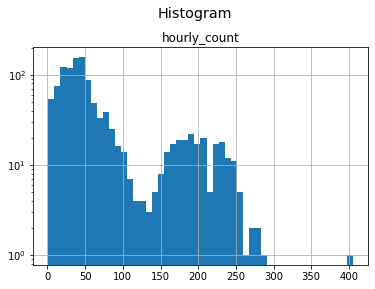

In [16]:
plot_df = tweets_hour.select('hourly_count').toPandas()

plot_df.hist(bins = 50)
plt.yscale('log')
plt.suptitle('Histogram',x=0.5, y=1.02, fontsize='x-large');

In [17]:
def convert_type(df,to_string=[], to_integer=[], to_double = []):
    col_names = df.columns
    
    if len(to_string) > 0:
        for col in to_string:
            df = df.withColumn(col,df[col].cast(StringType()))
    
    if len(to_integer) > 0:
        for col in to_integer:
            df = df.withColumn(col,df[col].cast(IntegerType()))
            
    if len(to_double) > 0:
        for col in to_double:
            df = df.withColumn(col,df[col].cast(DoubleType()))
            
    return df

In [18]:
def compute_metrics_reg(predictions, model_name, labelcol = 'target'):
    
    rmse_obj = RegressionEvaluator(metricName = 'rmse', predictionCol = 'prediction', labelCol = labelcol)
    
    rsquared_obj = RegressionEvaluator(metricName = 'r2', predictionCol = 'prediction', labelCol = labelcol)
    
    print(model_name, 'Metrics:\nRMSE Score:',\
          str(rmse_obj.evaluate(predictions))+ '\nR-Squared Value:',\
          str(rsquared_obj.evaluate(predictions)))

In [19]:
!pip install statsforecast



Defaulting to user installation because normal site-packages is not writeable


# AutoARIMA

In [20]:
#from statsforecast.distributed.utils import forecast
from statsforecast.distributed.fugue import FugueBackend
from statsforecast.models import AutoARIMA
from statsforecast.core import StatsForecast

In [21]:
df_hour = tweets_hour.select('sentiment', 'datetime', 'hourly_count') \
                        .withColumnRenamed('sentiment', 'unique_id') \
                        .withColumnRenamed('datetime', 'ds') \
                        .withColumnRenamed('hourly_count', 'y')
df_hour.printSchema()

root
 |-- unique_id: string (nullable = false)
 |-- ds: timestamp (nullable = true)
 |-- y: long (nullable = false)



In [22]:
from pyspark.sql import functions as F

# Filtrando o DataFrame para o período desejado (abril e maio de 2009)
df_filtered = df_hour.filter(
    (F.to_date(F.date_format('ds', 'yyyy-MM-dd')) >= '2009-04-01') & 
    (F.to_date(F.date_format('ds', 'yyyy-MM-dd')) <= '2009-05-31')
)


In [23]:
from pyspark.sql.functions import month

# Adicionando uma coluna 'month' ao DataFrame
df_with_month = df_hour.withColumn('month', month('ds'))

# Extraindo os valores únicos do mês
unique_months = df_with_month.select('month').distinct().collect()

# Exibindo os meses únicos
print("Meses disponíveis:")
for row in unique_months:
    print(row.month)


Meses disponíveis:
6
5
4


In [24]:
df_filtered.show()


+---------+-------------------+---+
|unique_id|                 ds|  y|
+---------+-------------------+---+
|        1|2009-04-07 05:00:00| 64|
|        0|2009-04-07 05:00:00| 17|
|        0|2009-04-07 06:00:00| 20|
|        1|2009-04-07 06:00:00| 85|
|        1|2009-04-07 07:00:00| 74|
|        0|2009-04-07 07:00:00| 15|
|        0|2009-04-07 08:00:00| 21|
|        1|2009-04-07 08:00:00| 65|
|        1|2009-04-07 09:00:00| 72|
|        0|2009-04-07 09:00:00|  6|
|        1|2009-04-07 10:00:00| 80|
|        0|2009-04-07 10:00:00| 24|
|        0|2009-04-07 11:00:00| 30|
|        1|2009-04-07 11:00:00| 76|
|        1|2009-04-07 12:00:00| 61|
|        0|2009-04-07 12:00:00| 20|
|        1|2009-04-07 13:00:00| 62|
|        0|2009-04-07 13:00:00| 18|
|        0|2009-04-07 14:00:00| 28|
|        1|2009-04-07 14:00:00| 76|
+---------+-------------------+---+
only showing top 20 rows



## Training and Testing

In [33]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format



hour_test = df_hour.withColumn("month", date_format("ds", "yyyy-MM-dd"))


train_ratio = 0.5  
test_ratio = 1.0 - train_ratio


def split_data_by_month(df, train_ratio, test_ratio, seed=42):
    train_df, test_df = df.randomSplit([train_ratio, test_ratio], seed=seed)
    return train_df, test_df


train_df, test_df = split_data_by_month(df_hour, train_ratio, test_ratio)


print("Training:", train_df.count(), "-> {:.2f}%".format((train_df.count() / df_hour.count()) * 100))
print("Testing:", test_df.count(), "-> {:.2f}%".format((test_df.count() / df_hour.count()) * 100))

# Caching the dataframe
hour_train_df = hour_train_df.drop('month')
hour_test_df = hour_test_df.drop('month')


# Caching the dataframe
hour_train_df.cache()
hour_test_df.cache()


# Schema
hour_train_df.printSchema()
hour_test_df.printSchema()

Training: 586 -> 49.79%


Testing: 591 -> 50.21%
root
 |-- unique_id: string (nullable = false)
 |-- ds: timestamp (nullable = true)
 |-- y: long (nullable = false)

root
 |-- unique_id: string (nullable = false)
 |-- ds: timestamp (nullable = true)
 |-- y: long (nullable = false)



In [34]:
n_test = int((hour_test.count())/2)

backend = FugueBackend(spark, {"fugue.spark.use_pandas_udf":True})

pred_hour = forecast(hour_train_df, 
                     [AutoARIMA(season_length = 24)], 
                     freq = "H", 
                     h = n_test,
                     level = [90],
                     parallel=backend)

pred_hour.printSchema()
pred_hour.count()

NameError: name 'forecast' is not defined